In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
#import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline

In [3]:
#Import gold data
gold = pd.read_csv('deccan_gold_price.csv')
print('Dimension of the data: ' + str(gold.shape))
gold.head()

Dimension of the data: (4812, 13)


,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
0,13-04-2023,50.47,50.47,47.86,49.15,49.35,122650,413,6053293,99475.0,81.10,2.61,-1.32
1,12-04-2023,49.98,51.00,49.30,50.07,49.99,193359,417,9665903,166630.0,86.18,1.70,0.09
2,11-04-2023,48.87,50.05,47.76,49.90,49.21,270964,509,13335488,208486.0,76.94,2.29,1.03
3,10-04-2023,51.49,51.49,48.00,48.16,49.90,339774,517,16954583,280083.0,82.43,3.49,-3.33
4,06-04-2023,48.40,49.04,47.65,49.04,48.80,245835,441,11996688,203526.0,82.79,1.39,0.64


In [4]:
gold_dumms = pd.get_dummies(gold, drop_first=True)
gold_dumms.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,...,Date_31-12-2009,Date_31-12-2010,Date_31-12-2012,Date_31-12-2013,Date_31-12-2014,Date_31-12-2015,Date_31-12-2018,Date_31-12-2019,Date_31-12-2020,Date_31-12-2021
0,50.47,50.47,47.86,49.15,49.35,122650,413,6053293,99475.0,81.10,...,0,0,0,0,0,0,0,0,0,0
1,49.98,51.00,49.30,50.07,49.99,193359,417,9665903,166630.0,86.18,...,0,0,0,0,0,0,0,0,0,0
2,48.87,50.05,47.76,49.90,49.21,270964,509,13335488,208486.0,76.94,...,0,0,0,0,0,0,0,0,0,0
3,51.49,51.49,48.00,48.16,49.90,339774,517,16954583,280083.0,82.43,...,0,0,0,0,0,0,0,0,0,0
4,48.40,49.04,47.65,49.04,48.80,245835,441,11996688,203526.0,82.79,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# using train_test_split:
X_train, X_rem, y_train, y_rem = train_test_split(gold[['Close', 'No. of Trades']], gold['Close'], train_size=0.7,
                                                  random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.3, random_state=123)

print('Dimension of training set: ', X_train.shape)
print('Dimension of validation set: ', X_valid.shape)
print('Dimension of test data: ', X_test.shape)

Dimension of training set:  (3368, 2)
Dimension of validation set:  (1010, 2)
Dimension of test data:  (434, 2)


[64.4294290200278, 5.771044640729752e-30, 5.771044640729752e-30, 5.771044640729752e-30, 5.771044640729752e-30, 5.771044640729752e-30, 5.771044640729752e-30, 5.771044640729752e-30, 5.771044640729752e-30, 5.771044640729752e-30, 5.771044640729752e-30, 5.771044640729752e-30, 5.771044640729752e-30, 5.771044640729752e-30, 5.771044640729752e-30]


Text(0, 0.5, 'MSPE')

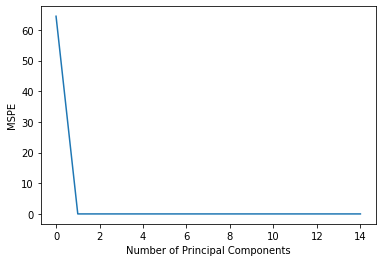

In [6]:
#PCR

std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

pca = PCA()
PCs_train = pca.fit_transform(X_train_std)
PCs_test = pca.transform(X_test_std)

LModel = linear_model.LinearRegression()
MSPEs = []
# Calculate MSPE: adding one component at a time
for i in np.arange(1, 16):
  LModel.fit(PCs_train[:,:i], y_train)
  MSPEs.append(mean_squared_error(y_test, LModel.predict(PCs_test[:,:i])))

print(MSPEs)

# Plot MSPEs results    
plt.plot(MSPEs)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSPE')

In [7]:
LModel.fit(PCs_train[:,:10], y_train)
print('MSPE: ', mean_squared_error(y_test, LModel.predict(PCs_test[:,:10])))
print('Coef estimatees: ', LModel.coef_)

MSPE:  5.771044640729752e-30
Coef estimatees:  [ 9.79047373 -9.79047373]


In [8]:
#Create dummy variavles and initialize 10-fold CV
# from numpy.core.fromnumeric import shape
gold_dumms['CV'] = np.random.randint(low=0, high=10, size=(gold_dumms.shape[0],))
print(gold_dumms['CV'].value_counts())
print(gold_dumms.isnull().sum())
gold_dumms

7    524
8    508
0    487
9    482
4    481
1    475
2    472
6    471
3    459
5    453
Name: CV, dtype: int64
Open               0
High               0
Low                0
Close              0
WAP                0
                  ..
Date_31-12-2018    0
Date_31-12-2019    0
Date_31-12-2020    0
Date_31-12-2021    0
CV                 0
Length: 4824, dtype: int64


,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,...,Date_31-12-2010,Date_31-12-2012,Date_31-12-2013,Date_31-12-2014,Date_31-12-2015,Date_31-12-2018,Date_31-12-2019,Date_31-12-2020,Date_31-12-2021,CV
0,50.47,50.47,47.86,49.15,49.350000,122650,413,6053293,99475.0,81.10,...,0,0,0,0,0,0,0,0,0,9
1,49.98,51.00,49.30,50.07,49.990000,193359,417,9665903,166630.0,86.18,...,0,0,0,0,0,0,0,0,0,9
2,48.87,50.05,47.76,49.90,49.210000,270964,509,13335488,208486.0,76.94,...,0,0,0,0,0,0,0,0,0,1
3,51.49,51.49,48.00,48.16,49.900000,339774,517,16954583,280083.0,82.43,...,0,0,0,0,0,0,0,0,0,3
4,48.40,49.04,47.65,49.04,48.800000,245835,441,11996688,203526.0,82.79,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807,6.25,6.25,6.25,6.25,6.250000,100,1,625,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
4808,4.85,4.85,4.85,4.85,4.850000,100,1,485,NaN,NaN,...,0,0,0,0,0,0,0,0,0,5
4809,3.75,3.75,3.75,3.75,3.746667,150,2,562,NaN,NaN,...,0,0,0,0,0,0,0,0,0,4
4810,2.90,2.90,2.90,2.90,2.900000,100,1,290,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#Model comparison:
Ridge_MSPE = []
LASSO_MSPE = []
LASSO_NFeat = []
PCR_MSPE = []
PCR_NCopm = []
PLS_MSPE = []
PLS_NCopm = []

for i in range(10):
  MBTI_dumms_train = gold_dumms.loc[gold_dumms['CV'] != i]
  MBTI_dumms_test = gold_dumms.loc[gold_dumms['CV'] == i]

  y_train = MBTI_dumms_train['No. of Trades']
  X_train = MBTI_dumms_train.drop(['Close', 'No. of Trades', 'CV'], axis=1)
  y_test = MBTI_dumms_test['No. of Trades']
  X_test = MBTI_dumms_test.drop(['Close', 'No. of Trades', 'CV'], axis=1)

  std_scale = StandardScaler().fit(X_train)
  X_train_std = std_scale.transform(X_train)
  X_test_std  = std_scale.transform(X_test)

  CV10 = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)

  # Ridge
  LMRidgeCV = RidgeCV(alphas=np.arange(0.5, 2, 0.01), cv=CV10, scoring='neg_mean_squared_error')
  LMRidgeCV.fit(X_train_std, y_train)
  LMRidge = Ridge(alpha = LMRidgeCV.alpha_)
  LMRidge.fit(X_train_std, y_train)
  Ridge_MSPE.append(mean_squared_error(y_test, LMRidge.predict(X_test_std)))

  # LASSO
  LMLassoCV = LassoCV(alphas = np.arange(0.5, 2, 0.01), cv = CV10, max_iter = 1000)
  LMLassoCV.fit(X_train_std, y_train)
  LMLasso = Lasso(max_iter = 10000)
  LMLasso.set_params(alpha=LMLassoCV.alpha_)
  LMLasso.fit(X_train_std, y_train)
  LASSO_MSPE.append(mean_squared_error(y_test, LMLasso.predict(X_test_std)))
  LASSO_NFeat.append(len(LMLasso.coef_) - sum(LMLasso.coef_ == 0))

  # PCR
  pca = PCA()
  LModel = linear_model.LinearRegression()
  for pcr_train_index, pcr_test_index in CV10.split(X_train_std):
    pcr_X_train, pcr_X_test = X_train_std[pcr_train_index], X_train_std[pcr_test_index]
    pcr_y_train, pcr_y_test = y_train.iloc[pcr_train_index], y_train.iloc[pcr_test_index]
    PCs_train = pca.fit_transform(pcr_X_train)
    PCs_test = pca.transform(pcr_X_test)
    PCR_MSPE_train = []
    for j in range(1, 16):
      LModel.fit(PCs_train[:,:j], pcr_y_train)
      PCR_MSPE_train.append(mean_squared_error(pcr_y_test, LModel.predict(PCs_test[:,:j])))

  PCR_NCopm.append(np.argmin(PCR_MSPE_train))
  PCs_train = pca.fit_transform(X_train_std)
  PCs_test = pca.transform(X_test_std)
  LModel.fit(PCs_train[:,:PCR_NCopm[i]], y_train)
  PCR_MSPE.append(mean_squared_error(y_test, LModel.predict(PCs_test[:,:PCR_NCopm[i]])))

  # PLS
  for pls_train_index, pls_test_index in CV10.split(X_train_std):
    pls_X_train, pls_X_test = X_train_std[pcr_train_index], X_train_std[pcr_test_index]
    pls_y_train, pls_y_test = y_train.iloc[pcr_train_index], y_train.iloc[pcr_test_index]
    PLS_MSPE_train = []
    for j in range(1, 16):
      plsr = PLSRegression(n_components=j, scale=True)
      plsr.fit(pls_X_train, pls_y_train)
      PLS_MSPE_train.append(mean_squared_error(pls_y_test, plsr.predict(pls_X_test)))

  PLS_NCopm.append(np.argmin(PLS_MSPE_train))
  plsr = PLSRegression(n_components=PLS_NCopm[i], scale=True)
  plsr.fit(X_train_std, y_train)
  PLS_MSPE.append(mean_squared_error(y_test, plsr.predict(X_test_std)))


print(Ridge_MSPE)
print(LASSO_MSPE)
print(LASSO_NFeat)
print(PCR_MSPE)
print(PCR_NCopm)
print(PLS_MSPE)
print(PLS_NCopm)

ValueError: 
All the 1500 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1500 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Pishtaz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Pishtaz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py", line 1122, in fit
    X, y = self._validate_data(
  File "c:\Users\Pishtaz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\Pishtaz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 1074, in check_X_y
    X = check_array(
  File "c:\Users\Pishtaz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 899, in check_array
    _assert_all_finite(
  File "c:\Users\Pishtaz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 146, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
